# M&A Prediction with Risk (S&P 500)

Part I Project Overview - This project identifies private equity targets within the S&P500 using a structured financial screening framework. It applies clear and practical investment logic to highlight companies that align with typical buyout characteristics.

Ticker Collection

In [2]:
import pandas as pd

df = pd.read_csv("constituents.csv")
df["Symbol"] = df["Symbol"].str.replace(".", "-", regex=False)
symbols = df["Symbol"].tolist()

print("Total companies:", len(symbols))
print("Sample tickers:", symbols[:10])

Total companies: 503
Sample tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']


Filtering by sector 

In [3]:
pe_sectors = [
    "Technology",
    "Healthcare",
    "Industrials",
    "Real Estate",
    "Consumer Discretionary",
    "Financials",
    "Energy"
]

df_sector_filtered = df[df["GICS Sector"].isin(pe_sectors)].reset_index(drop=True)

print("Remaining after sector filter:", len(df_sector_filtered))
df_sector_filtered.head()

Remaining after sector filter: 256


,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,AFL,Aflac,Financials,Life & Health Insurance,"Columbus, Georgia",1999-05-28,4977,1955
3,ABNB,Airbnb,Consumer Discretionary,"Hotels, Resorts & Cruise Lines","San Francisco, California",2023-09-18,1559720,2008
4,ARE,Alexandria Real Estate Equities,Real Estate,Office REITs,"Pasadena, California",2017-03-20,1035443,1994


Gather financial metrics through yfinance

In [4]:
import yfinance as yf
import time

symbols = df_sector_filtered["Symbol"].tolist()
financials = []

for symbol in symbols:
    try:
        stock = yf.Ticker(symbol)
        info = stock.info

        financials.append({
            "Symbol": symbol,
            "Market_Cap": info.get("marketCap"),
            "EBITDA_Margin": info.get("ebitdaMargins"),
            "ROA": info.get("returnOnAssets"),
            "Debt_Equity": info.get("debtToEquity"),
            "Sector": info.get("sector"),
            "Sub_Industry": info.get("industry")
        })

        time.sleep(0.5)
    except Exception as e:
        print(symbol, "error:", e)

df_fin = pd.DataFrame(financials)
df_fin.to_csv("filtered_sector_financials.csv", index=False)
df_fin.head()

,Symbol,Market_Cap,EBITDA_Margin,ROA,Debt_Equity,Sector,Sub_Industry
0,MMM,72980520960,0.22258,0.05929,350.770,Industrials,Conglomerates
1,AOS,9167196160,0.20364,0.13533,12.132,Industrials,Specialty Industrial Machinery
2,AFL,58980765696,0.35156,0.03384,37.796,Financial Services,Insurance - Life
3,ABNB,71230423040,0.23275,0.07671,27.271,Consumer Cyclical,Travel Services
4,ARE,13684294656,0.62756,0.01419,56.930,Real Estate,REIT - Office


Prioritize companies with solid size healthy profitability and manageable debt

In [13]:
# Market cap filter (1B-30B)
df1 = df_fin[
    (df_fin["Market_Cap"] >= 1e9) &
    (df_fin["Market_Cap"] <= 3e10)
]
print("After Market Cap filter:", df1.shape[0])

#Profitability filter (EBITDA margin ≥ 10%, ROA > 0)
df2 = df1[
    (df1["EBITDA_Margin"] >= 0.10) &
    (df1["ROA"] > 0)
]
print("After Profitability filter:", df2.shape[0])

#Leverage filter (D/E < 4.0)
df3 = df2[df2["Debt_Equity"] < 4.0]
print("After Leverage filter:", df3.shape[0])

#Final target candidates
df3.reset_index(drop=True, inplace=True)
df3.to_csv("pe_target_candidates_filtered.csv", index=False)
df3.head()


After Market Cap filter: 111
After Profitability filter: 93
After Leverage filter: 3


,Symbol,Market_Cap,EBITDA_Margin,ROA,Debt_Equity,Sector,Sub_Industry
0,ERIE,21947117568,0.20193,0.16552,0.378,Financial Services,Insurance Brokers
1,TROW,19463954432,0.39812,0.11412,2.950,Financial Services,Asset Management
2,TPL,29079910400,0.80685,0.28298,0.110,Energy,Oil & Gas E&P


Summary

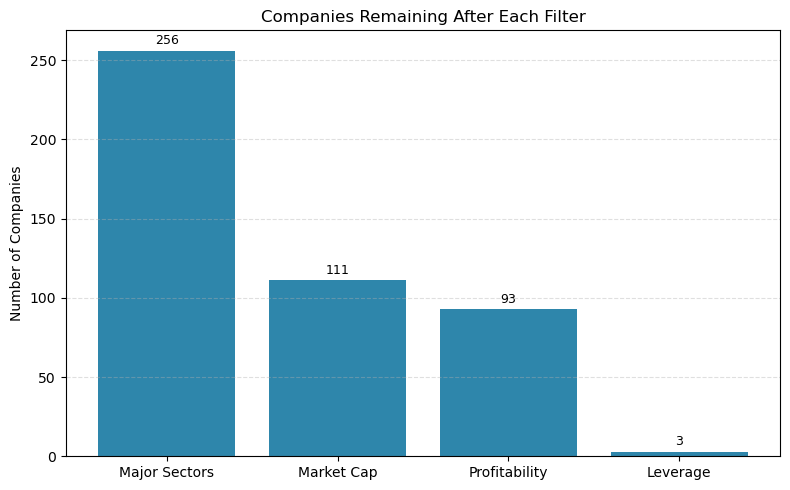

In [22]:
import matplotlib.pyplot as plt

filter_counts = {
    "Major Sectors": df_fin.shape[0],
    "Market Cap": df1.shape[0],
    "Profitability": df2.shape[0],
    "Leverage": df3.shape[0]
}

x = list(filter_counts.keys())
y = list(filter_counts.values())

plt.figure(figsize=(8, 5))
bars = plt.bar(x, y, color="#2E86AB")

for b in bars:
    h = b.get_height()
    plt.text(b.get_x() + b.get_width()/2, h + 2, f'{h}', ha='center', va='bottom', fontsize=9)

plt.title("Companies Remaining After Each Filter")
plt.ylabel("Number of Companies")
plt.grid(axis="y", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.savefig("filter_step_summary.png", dpi=300)
plt.show()



Comparison of final candiates

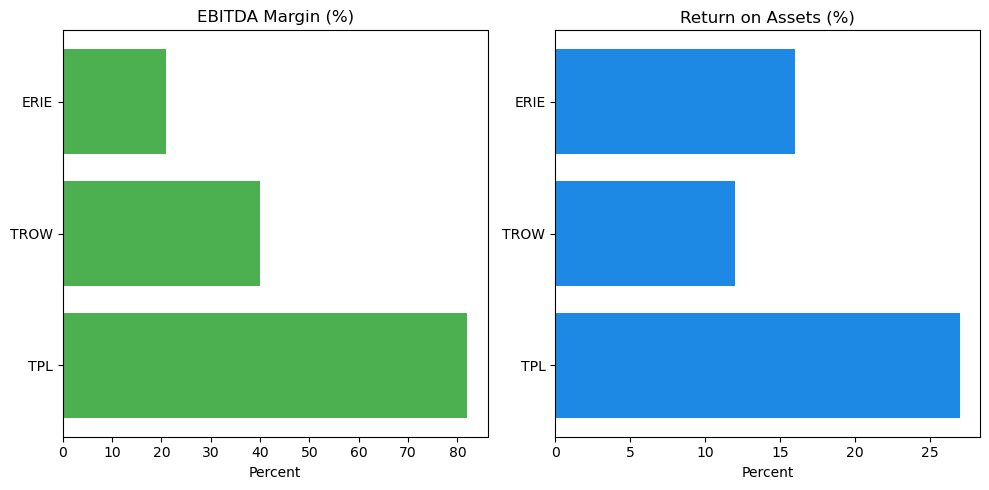

In [ ]:
final = df3.copy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].barh(final["Symbol"], final["EBITDA_Margin"] * 100, color="#4CAF50")
axs[0].set_title("EBITDA Margin (%)")
axs[0].set_xlabel("Percent")

axs[1].barh(final["Symbol"], final["ROA"] * 100, color="#1E88E5")
axs[1].set_title("Return on Assets (%)")
axs[1].set_xlabel("Percent")

plt.tight_layout()
plt.savefig("final_candidates_comparison_v2.png", dpi=300)
plt.show()
